# Plotting ChIP signal around TSS of DEGs after 24h NipBL while measuring background levels

- adding a split for quantiles of WT expression levels for non-DE genes
- Using: vst normalized counts for quantifying expression levels
- Splitting by: bottom 25% counts, 25-50%, 50-75%, 75-100% for all genes tagged as non-significant

In [1]:
import plotting_heatmap_functions as pfn

In [2]:
import pandas as pd
import numpy as np
import bbi
from gffutils.helpers import asinterval
from gtfparse import read_gtf
import bioframe as bf
import matplotlib.pyplot as plt

In [3]:
# Importing day 1 depletion in ESCs DEGS

proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"

day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized.csv'

vst_normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized_vst-transformed.csv'

feature_counts = '20220816_featureCounts.csv'

WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']

In [4]:
day1_res_df = pd.read_csv(proj+day1_sigRes)

importing the rest of the feature counts to collect the set of non-significantly DE genes

In [5]:
feat_counts_df = pd.read_csv(proj+feature_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
feat_counts_df.shape

(55421, 109)

In [6]:
feat_counts_df['avg'] = feat_counts_df[WT_samples].mean(axis='columns')

Comparing with average of vst_normalized_counts

In [7]:
vst_counts_df = pd.read_csv(proj+vst_normalized_counts).rename(columns={'Unnamed: 0' : 'Geneid'})

In [8]:
vst_counts_df['avg'] = vst_counts_df[WT_samples].mean(axis='columns')

In [9]:
feat_counts_df = feat_counts_df.merge(vst_counts_df, on='Geneid', how='left', suffixes=('_counts', '_vst_counts'))

In [10]:
feat_counts_df.shape

(55421, 123)

In [11]:
day1_res_df = day1_res_df.merge(feat_counts_df[['Geneid', 'avg_counts', 'avg_vst_counts']], on='Geneid', how='outer')

In [12]:
day1_res_df['avg_vst_counts'].isna().sum()

18975

In [13]:
day1_res_df['avg_vst_counts'].fillna(0, inplace=True)

In [14]:
#day1_res_df[day1_res_df['avg_counts'] == 0]

Getting the TSSes 

Note: assuming that the RNA-seq alignment is still being done via STAR method from 

In [15]:
# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


In [16]:
# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
tss_df["seqname"] = tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

# Removing pseudo chromosomes
before = len(tss_df)
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrGL'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrJH'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrX'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrY'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrM'))]
tss_df =tss_df.loc[True==tss_df['chrom'].str.contains('chr')]
after = len(tss_df)

In [17]:
# drop duplicate TSSes
ts_intervals = tss_df[['gene_id','chrom', 'start', 'end']].drop_duplicates(['gene_id'])

In [18]:
# drop gene from data field if there is no change associated
# day1_res_df.dropna(subset=['log2FoldChange'], inplace=True)
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

In [19]:
day1_res_df.head(3)

,Geneid,SYMBOL,log2FoldChange,padj,baseMean,avg_counts,avg_vst_counts,gene_id,chrom,start,end
0,ENSMUSG00000025128.7,Bhlhe22,-4.479336,4.277827e-03,7.794735,11.166667,6.255218,ENSMUSG00000025128.7,chr3,18054173.0,18054173.0
1,ENSMUSG00000051314.11,Ffar2,-3.910856,3.800000e-06,31.133503,28.333333,6.711927,ENSMUSG00000051314.11,chr7,30823776.0,30823776.0
2,ENSMUSG00000057182.15,Scn3a,-3.806326,5.010000e-18,144.877936,150.666667,8.010170,ENSMUSG00000057182.15,chr2,65567493.0,65567493.0


In [20]:
# Checking if any of the significant genes will be lost due to loss of TSS annotation
print("Checking for 'lost' significant genes: ")
ix = np.where(day1_res_df['start'].isna() & (day1_res_df['padj'] < 0.05))
print("lost: ", str(day1_res_df.iloc[ix].shape[0]))

# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

Checking for 'lost' significant genes: 
lost:  55


In [21]:
day1_res_df = bf.sanitize_bedframe(day1_res_df)

In [22]:
day1_res_df['log2FoldChange'].tail(1).isna()

51164    True
Name: log2FoldChange, dtype: bool

Let's look at the values for counts of the genes that do not make the pval cutoff of 0.05:

In [23]:
cutoff_col = 'padj'
pval_cutoff = 0.05

In [24]:
#day1_res_df[day1_res_df[cutoff_col].isna()]

any rows left that are just labeled nonsig?

## Generating average Chip-signal plots with lines for all percentiles

In [25]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf_new = "CTCF_E14_RSC13new-22-37-60_average.bw"
rad21 = "RAD21_E14_RSC12new-21-36-59-74_average.bw"
nipbl = "NIPBL_E14_EA112-EA175_average.bw"
ring1b = "RING1B_E14_RSC24-39-62_average.bw"
promoter = "H3K27Ac_mESCs_EA92-EA94_average.bw"

In [26]:
chip_seq_condition_dict = {'CTCF' : chip_folder+ctcf_new, 'RAD21' : chip_folder+rad21,
                           'NiBL' : chip_folder+nipbl, 'RING1B' : chip_folder+ring1b,
                           'H3K27ac' : chip_folder+promoter}

## Separating non-significant genes by quartiles of vst counts

In [27]:
percentiles = [25, 50, 75, 100]
print(np.percentile(day1_res_df[day1_res_df[cutoff_col].isna()]['avg_vst_counts'], percentiles))

quartiles = np.percentile(day1_res_df[day1_res_df[cutoff_col].isna()]['avg_vst_counts'], percentiles)

[ 0.          5.72776221  6.56572893 17.72303874]


In [28]:
def label_DE_status_deseq2_nonsig_quartiles(gene_row):
    
    cutoff_col = 'padj'
    pval_cutoff = 0.05
    de_value_col = 'log2FoldChange'
    
    if gene_row[cutoff_col] < pval_cutoff:
        if gene_row[de_value_col] < 0:
            return 'down'
        else:
            return 'up'
    else:
        count_values = quartiles
        percentiles = [25, 50, 75, 100]
        for val,perc in zip(count_values, percentiles):
            if gene_row['avg_vst_counts'] <= val:
                return 'nonsig_counts_'+str(perc)+'%'
        return 'nonsig_counts_other'

In [29]:
day1_res_df['DE_status'] = day1_res_df.apply(lambda row: label_DE_status_deseq2_nonsig_quartiles(row), axis=1)

In [30]:
day1_res_df['DE_status'].value_counts()

nonsig_counts_25%     16285
nonsig_counts_100%    12387
nonsig_counts_75%     12385
nonsig_counts_50%      8489
up                      837
down                    727
Name: DE_status, dtype: int64

In [33]:
cond = 'CTCF'

matrix = pfn.generate_signal_matrix(
                                day1_res_df,
                                chip_seq_condition_dict[cond]
                               )

In [34]:
categories = list(day1_res_df['DE_status'].unique())
greys = ['#f0f0f0','#d9d9d9', '#969696','#737373','#525252','#252525','#000000']
colors = ['r', 'b'] + greys[0:(len(categories)-2)]

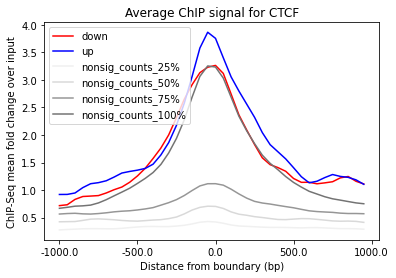

In [35]:
pfn.plot_avg_signal(day1_res_df, 
                    matrix, 
                    'Average ChIP signal for {}'.format(cond), 
                    ax=None, 
                    DE_value_col='log2Fold_Change',
                    agg_key='DE_status', 
                    agg_categories=categories, 
                    color_categories=colors, 
                    window_size=1000, 
                    nbins=40)

# Generate average signal plots for all proteins

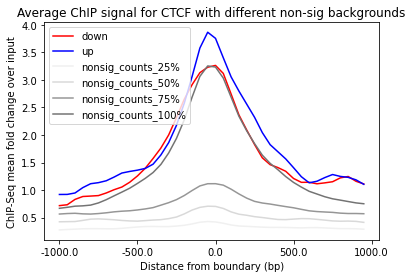

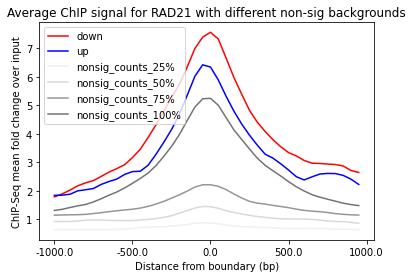

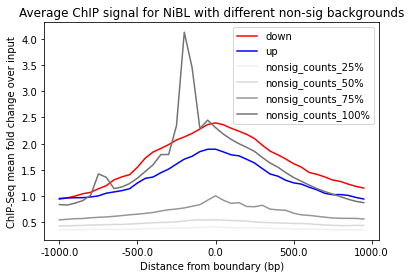

In [ ]:
# Plot for all categories
for cond, chip_file in chip_seq_condition_dict.items():
    

    matrix = pfn.generate_signal_matrix(day1_res_df, 
                                chip_file)
    
    pfn.plot_avg_signal(day1_res_df, 
                    matrix, 
                    'Average ChIP signal for {} with different non-sig backgrounds'.format(cond), 
                    ax=None, 
                    DE_value_col='log2Fold_Change',
                    agg_key='DE_status', 
                    agg_categories=categories, 
                    color_categories=colors, 
                    window_size=1000, 
                    nbins=40)
    
    plt.show()


## Deprecated:

- Other ways to break the non-significant genes:
    - by other percentiles
    - by specific cut-off
    - using non-normalized counts

In [31]:
percentiles = [25, 50, 75, 80, 90, 100]
print(np.percentile(day1_res_df[day1_res_df[cutoff_col].isna()]['avg_counts'], percentiles))

[0.00000000e+00 5.00000000e-01 2.08333333e+01 6.81666667e+01
 7.76333333e+02 2.02678333e+05]


In [32]:
# def label_DE_status_deseq2(gene_row):
    
#     cutoff_col = 'padj'
#     pval_cutoff = 0.05
#     de_value_col = 'log2FoldChange'
    
#     if gene_row[cutoff_col] < pval_cutoff:
#         if gene_row[de_value_col] < 0:
#             return 'down'
#         else:
#             return 'up'
#     else:
#         if gene_row['avg_Counts'] <= 0:
#             return 'nonsig_25'
#         elif gene_row['avg_Counts'] <= 5.73517253e+00:
#             return 'nonsig_50'
#         elif gene_row['avg_Counts'] <= 9.44590677e+00:
#             return 'nonsig_75'
#         elif gene_row['avg_Counts'] <= 1.10435574e+01:
#             return 'nonsig_80'
#         elif gene_row['avg_Counts'] <= 1.67833333e+02:
#             return 'nonsig_90'
#         else:
#             return 'nonsig_100'

In [33]:
def label_DE_status_deseq2_nonsig_counts(gene_row):
    
    cutoff_col = 'padj'
    pval_cutoff = 0.05
    de_value_col = 'log2FoldChange'
    
    if gene_row[cutoff_col] < pval_cutoff:
        if gene_row[de_value_col] < 0:
            return 'down'
        else:
            return 'up'
    else:
        count_values = [1.0e-01, 1.0e+00, 1.0e+01, 1.0e+02]
        for val in count_values:
            if gene_row['avg_vst_counts'] <= val:
                return 'nonsig_counts_under_'+str(val)
        return 'nonsig_counts_over_'+str(count_values(-1))

In [34]:
day1_res_df['DE_status'] = day1_res_df.apply(lambda row: label_DE_status_deseq2_nonsig_counts(row), axis=1)

In [35]:
day1_res_df.tail(3)

,Geneid,SYMBOL,log2FoldChange,padj,baseMean,avg_counts,avg_vst_counts,gene_id,chrom,start,end,DE_status
51162,ENSMUSG00000117951.1,NaN,NaN,NaN,NaN,2.666667,5.976309,ENSMUSG00000117951.1,chr19,61257790,61257790,nonsig_counts_under_10.0
51163,ENSMUSG00000095993.1,NaN,NaN,NaN,NaN,15.000000,6.379612,ENSMUSG00000095993.1,chr19,61297070,61297070,nonsig_counts_under_10.0
51164,ENSMUSG00000118197.1,NaN,NaN,NaN,NaN,19.000000,6.560100,ENSMUSG00000118197.1,chr19,61305281,61305281,nonsig_counts_under_10.0


Check to make sure this grouping by percentiles made sense/worked

In [36]:
day1_res_df['DE_status'].value_counts()

nonsig_counts_under_10.0     28661
nonsig_counts_under_0.1      16285
nonsig_counts_under_100.0     4600
up                             837
down                           727
Name: DE_status, dtype: int64

### test: generate one plot firts for CTCF

In [39]:
cond = 'CTCF'

matrix = pfn.generate_signal_matrix(
                                day1_res_df,
                                chip_seq_condition_dict[cond]
                               )

In [40]:
categories = list(day1_res_df['DE_status'].unique())
greys = ['#f0f0f0','#d9d9d9', '#969696','#737373','#525252','#252525','#000000']
colors = ['r', 'b'] + greys[0:(len(categories)-2)]

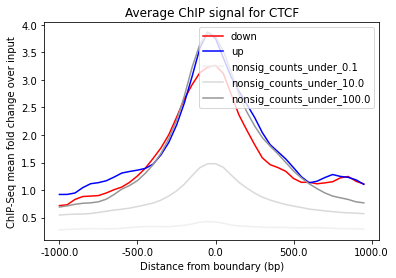

In [41]:
    
pfn.plot_avg_signal(day1_res_df, 
                    matrix, 
                    'Average ChIP signal for {}'.format(cond), 
                    ax=None, 
                    DE_value_col='log2Fold_Change',
                    agg_key='DE_status', 
                    agg_categories=categories, 
                    color_categories=colors, 
                    window_size=1000, 
                    nbins=40)

plt.show()